In [6]:
import SimpleITK as sitk
import numpy as np
import cv2
import os
import random
import shutil
from ultralytics import YOLO

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt



train_results = pd.read_csv('../radiological_gradings.csv')
train_results = train_results.loc[:, ['Patient','IVD label','Pfirrman grade']]
train_results


pfirrman_map = {
    (row.Patient, row["IVD label"]): row["Pfirrman grade"]
    for _, row in train_results.iterrows()
}



patient_id = 237
img_path = f"../images/{patient_id}_t2.mha"
mask_path = f"../masks/{patient_id}_t2.mha"

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

arr_img = sitk.GetArrayFromImage(sitk_img)  # shape: [H, W, slices]
arr_mask = sitk.GetArrayFromImage(sitk_mask)

print("Obraz:", arr_img.shape, "Maska:", arr_mask.shape)


Obraz: (495, 516, 18) Maska: (495, 516, 18)


In [62]:
def show_disc(img_slice, mask_slice, patient_id=237, size=128):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    disc_ids = [201, 202, 203, 204, 205]

    mask_path = f"SPIDER_cleaned/masks/{patient_id}_t2.mha"
    image_path = f"SPIDER_cleaned/images/{patient_id}_t2.mha"

    
    dimensions = get_disc_dimensions(mask_path, image_path)
        

    img_rgb = cv2.cvtColor(
        cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.COLOR_GRAY2BGR
    )

    bboxes = {}

    # --- bboxy ---
    for did in disc_ids:
        ys, xs = np.where(mask_slice == did)
        if len(xs) == 0:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        bboxes[did] = (x_min, x_max, y_min, y_max)

        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img_rgb, str(did), (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    n_discs = len(bboxes)
    fig, axes = plt.subplots(
        2, 1 + n_discs,
        figsize=(4 * (1 + n_discs), 9),
        gridspec_kw={"height_ratios": [1, 0.6]}
    )

    preds_res = preds(patient_id)
    print(preds_res)
        # --- górny wiersz ---
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title("Whole spine")
    axes[0, 0].axis("off")

    for i, (did, (x_min, x_max, y_min, y_max)) in enumerate(bboxes.items()):
        disc_crop = img_slice[y_min:y_max+1, x_min:x_max+1]
        disc_norm = 255.0 * (disc_crop - disc_crop.min()) / (disc_crop.max() - disc_crop.min() + 1e-6)
        disc_norm = disc_norm.astype(np.uint8)
        disc_resized = cv2.resize(disc_norm, (size, size))

        axes[0, i + 1].imshow(disc_resized, cmap="gray")
        axes[0, i + 1].set_title(f"Disc {did}")
        axes[0, i + 1].axis("off")


    for j in range(1 + n_discs):
        axes[1,j].axis("off")
    for i, (did, dims) in enumerate(dimensions.items()):
        text = (f"Disc {did}\n"
                f"Depth: {dims['depth_mm']:.1f} mm\n"
                f"Width: {dims['width_mm']:.1f} mm\n"
                f"Height: {dims['height_mm']:.1f} mm\n"
                f"Prediction: Grade: {preds_res[i]}")
        axes[1, i + 1].text(0.5, 0.5, text, fontsize=12, ha='center', va='center')
    plt.suptitle(f"Patient {patient_id} - Information table")

    plt.tight_layout()
    plt.show()

Spacing: x=4.78, y=0.68, z=0.80 mm
Brak obrazów dla pacjenta 201
[]


IndexError: list index out of range

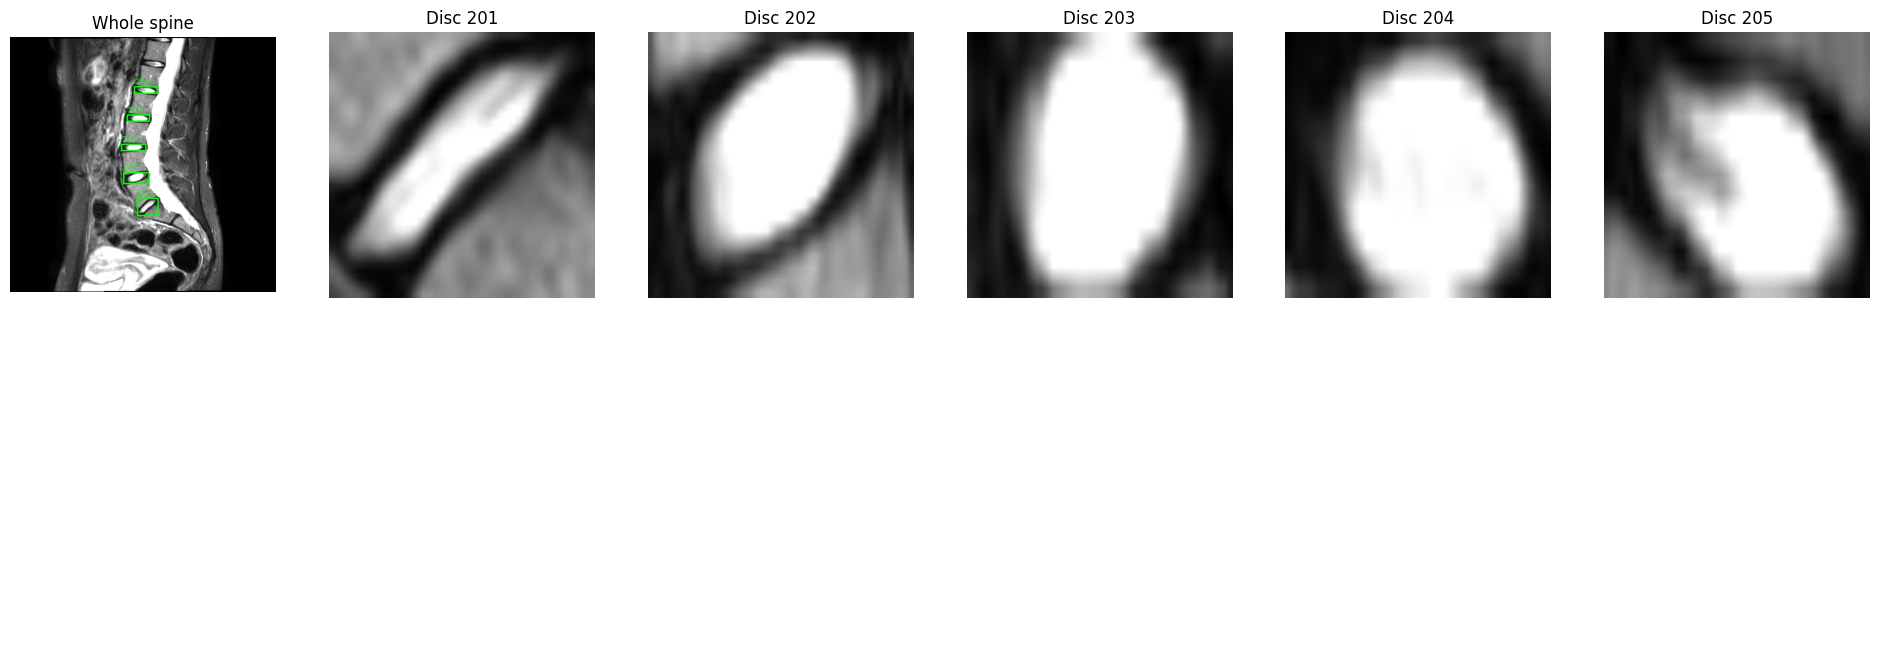

In [69]:
mid = arr_img.shape[2] // 2
slices_to_take = [mid-1, mid, mid+1]
disc_id = 201

img_slice = np.flipud(arr_img[:, :, slices_to_take[1]])
mask_slice = np.flipud(arr_mask[:, :, slices_to_take[1]])


show_disc(img_slice, mask_slice, disc_id)


In [ ]:
import numpy as np
import SimpleITK as sitk
import os

def get_disc_dimensions(mask_path, image_path=None):
    """
    Oblicza głębokość i szerokość każdego dysku z maski 3D.
    
    Parameters:
    -----------
    mask_path : str
        Ścieżka do pliku maski .mha
    image_path : str, optional
        Ścieżka do obrazu .mha (jeśli potrzebny spacing)
    
    Returns:
    --------
    dict: Wymiary każdego dysku w mm
    """
    # Wczytaj maskę
    mask_itk = sitk.ReadImage(mask_path)
    mask_np = sitk.GetArrayFromImage(mask_itk)  # (Z, Y, X)
    
    # Pobierz spacing (rozdzielczość)
    if image_path and os.path.exists(image_path):
        image_itk = sitk.ReadImage(image_path)
        spacing = image_itk.GetSpacing()  # (x, y, z) w mm
    else:
        # Jeśli nie ma obrazu, użyj spacing z maski lub domyślnego
        spacing = mask_itk.GetSpacing()
        if spacing[0] == 1.0 and spacing[1] == 1.0 and spacing[2] == 1.0:
            # Domyślny spacing dla MRI kręgosłupa
            spacing = (0.5, 0.5, 3.0)  # typowe wartości
    
    # Wypisz spacing dla informacji
    print(f"Spacing: x={spacing[0]:.2f}, y={spacing[1]:.2f}, z={spacing[2]:.2f} mm")
    
    # Znajdź wszystkie dyski (bez tła=0)
    disc_ids = np.unique(mask_np)
    disc_ids = disc_ids[disc_ids != 0]
    
    results = {}
    
    for disc_id in disc_ids:
        if disc_id >=201 and disc_id <=205:
            # Maska tylko tego dysku
            disc_mask = (mask_np == disc_id)
            
            # Znajdź voxele należące do dysku
            z_indices, y_indices, x_indices = np.where(disc_mask)
            
            if len(z_indices) == 0:
                continue
            
            # Oblicz zakresy w każdej osi
            z_min, z_max = z_indices.min(), z_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()
            x_min, x_max = x_indices.min(), x_indices.max()
            
            # Oblicz wymiary w mm
            # Głębokość (grubość) w osi Z (liczba slice'ów)
            depth_mm = (z_max - z_min + 1) * spacing[2]
            
            # Szerokość w osi X (od boku do bodu)
            width_mm = (x_max - x_min + 1) * spacing[0]
            
            # Wysokość w osi Y (przednio-tylna)
            height_mm = (y_max - y_min + 1) * spacing[1]
            
            # Objętość dysku
            volume_voxels = np.sum(disc_mask)
            volume_mm3 = volume_voxels * spacing[0] * spacing[1] * spacing[2]
            
            results[disc_id] = {
                'depth_mm': round(depth_mm, 2),
                'width_mm': round(width_mm, 2),
                'height_mm': round(height_mm, 2),
                'voxel_count': volume_voxels,
                'z_slices': z_max - z_min + 1
            }
            
            #rint(f"Dysk {disc_id}: głębokość={depth_mm:.1f}mm, szerokość={width_mm:.1f}mm, wysokość={height_mm:.1f}mm")
        
    return results

# Przykład użycia:
if __name__ == "__main__":
    # Ścieżki do plików
    mask_path = f"SPIDER_cleaned/masks/{patient_id}_t2.mha"
    image_path = f"SPIDER_cleaned/images/{patient_id}_t2.mha"
    
    if os.path.exists(mask_path):
        dimensions = get_disc_dimensions(mask_path, image_path)
        
        # Wypisz wyniki
        print("\nPodsumowanie:")
        for disc_id, dims in dimensions.items():
            print(f"Dysk {disc_id}:")
            print(f"  Depth: {dims['depth_mm']} mm")
            print(f"  Width: {dims['width_mm']} mm")
            print(f"  Height:  {dims['height_mm']} mm")
    else:
        print(f"Plik maski nie istnieje: {mask_path}")

Spacing: x=4.40, y=0.60, z=0.62 mm

Podsumowanie:
Dysk 201:
  Depth: 21.83 mm
  Width: 35.17 mm
  Height:  25.69 mm
Dysk 202:
  Depth: 13.72 mm
  Width: 43.96 mm
  Height:  30.46 mm
Dysk 203:
  Depth: 8.73 mm
  Width: 39.57 mm
  Height:  29.87 mm
Dysk 204:
  Depth: 9.36 mm
  Width: 39.57 mm
  Height:  29.27 mm
Dysk 205:
  Depth: 10.6 mm
  Width: 35.17 mm
  Height:  28.67 mm


In [33]:


from ultralytics import YOLO
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

VAL_DIR = "SPIDER_training_margin5_patient_split/train"
MODEL_PATH = "best_yolo.pt"

model = YOLO(MODEL_PATH)


In [72]:
import os
import re
from ultralytics import YOLO

def preds(patient_id):
    VAL_DIR = "SPIDER_training_margin5_patient_split/train"
    MODEL_PATH = "best_yolo.pt"
    
    model = YOLO(MODEL_PATH)
    patient_id_str = str(patient_id)
    found_disks = {}
    images_info = []  # Lista krotek (ścieżka, grade, disk_num)

    # Znajdź po jednym obrazie dla każdego dysku
    for grade_folder in os.listdir(VAL_DIR):
        grade_path = os.path.join(VAL_DIR, grade_folder)
        
        if not os.path.isdir(grade_path) or not grade_folder.startswith("grade"):
            continue
        
        try:
            grade = int(grade_folder.replace("grade", ""))
        except:
            continue
        
        for img_file in os.listdir(grade_path):
            if not img_file.startswith(f"patient{patient_id_str}_") or not img_file.endswith(".png"):
                continue
            
            disk_match = re.search(r'disk(\d+)', img_file)
            if disk_match:
                disk_num = int(disk_match.group(1))
                
                if disk_num not in found_disks:
                    found_disks[disk_num] = True
                    images_info.append((os.path.join(grade_path, img_file), grade, disk_num))
                    break  

    if not images_info:
        print(f"Brak obrazów dla pacjenta {patient_id}")
        return []

    # Posortuj według numeru dysku
    images_info.sort(key=lambda x: x[2])
    
    # Wykonaj predykcje
    predictions = []
    
    for img_path, grade, disk_num in images_info:
        try:    
            print(img_path)
            results = model.predict(img_path, verbose=False, save=False)
            if results and hasattr(results[0], "probs") and results[0].probs is not None:
                pred_class = int(results[0].probs.top1) + 1
            else:
                pred_class = 0
            predictions.append(pred_class)
        except Exception as e:
            print(f"Błąd dla {os.path.basename(img_path)}: {e}")
            predictions.append(0)

    print(f"Predykcje dla pacjenta {patient_id}: {predictions}")
    return predictions

In [73]:
preds(237)

SPIDER_training_margin5_patient_split/train\grade1\patient237_disk201_slice-1_pf1.png
Predykcje dla pacjenta 237: [1]


[1]

In [37]:
images

['SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk201_slice-1_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk201_slice-2_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk201_slice0_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk201_slice1_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk201_slice2_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk202_slice-1_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk202_slice-2_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk202_slice0_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk202_slice1_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk202_slice2_pf1.png',
 'SPIDER_training_margin5_patient_split/train\\grade1\\patient237_disk203_slice-1_pf1.